In [1]:
%cd ..

/home/feodor/Jupyter/depth-poset


/home/feodor/Jupyter/jupyter-env/lib/python3.12/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [81]:
import numpy as np
import scipy as sp
import pandas as pd
import gudhi as gh
import networkx as nx

from matplotlib import pyplot as plt

from src.depth import DepthPoset
from src.drow import plot_filtred_complex2d, plot_simplex, enumerate_points

# Define SImplicial Trees and Depth Posets

In [3]:
def get_random_reordered_stree(stree, change=1.):
    order = np.array([simplex for simplex, value in stree.get_filtration()], dtype=object)
    dims = np.array([len(s) for s in order])
    new_order = []
    for dim in np.unique(dims):
        order_dim = order[dims == dim]
        old_index_change = np.random.choice(np.arange(len(order_dim)), int(change*len(order_dim)), replace=False)
        new_index_change = np.random.choice(old_index_change, len(old_index_change), replace=False)
        order_dim[old_index_change] = order_dim[new_index_change]
        new_order.extend(order_dim)
        
    new_stree = gh.SimplexTree()
    for value, simplex in enumerate(new_order):
        new_stree.insert(simplex, value)
    return new_stree

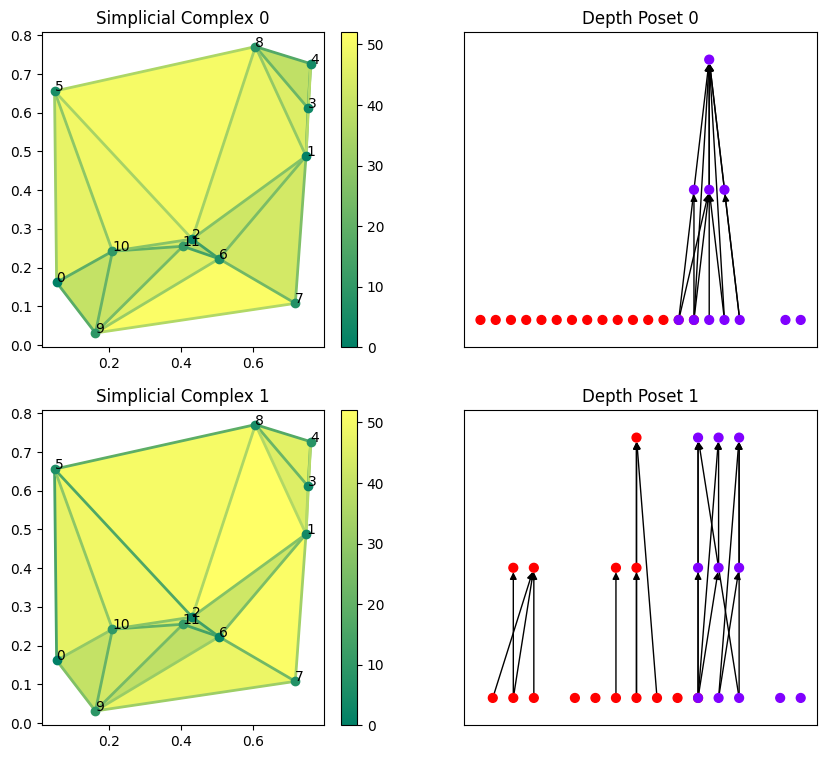

In [4]:
n = 12
dim = 2
points = np.random.random([n, dim])

stree = gh.AlphaComplex(points).create_simplex_tree()
order = []
for d in range(dim + 1):
    for simplex, value in stree.get_filtration():
        if len(simplex) == d + 1:
            order.append(simplex)
stree0 = gh.SimplexTree()
for value, simplex in enumerate(order):
    stree0.insert(simplex, value)

dp0 = DepthPoset.from_simplex_tree(stree0)


stree1 = get_random_reordered_stree(stree0, change=0.5)
dp1 = DepthPoset.from_simplex_tree(stree1)

fig, axs = plt.subplots(2, 2, figsize=(10, 9))

for i, (stree, dp) in enumerate(zip([stree0, stree1], [dp0, dp1])):
    axs[i, 0].set_title(f'Simplicial Complex {i}')
    sm = plot_filtred_complex2d(stree, points, cmap='summer', ax=axs[i, 0])
    plt.colorbar(sm, ax=axs[i, 0])
    enumerate_points(points, ax=axs[i, 0])
    
    axs[i, 1].set_title(f'Depth Poset {i}')
    cmap = plt.get_cmap('rainbow')
    node_colors = [cmap(node.dim/(dim - 1)) for node in dp0.nodes]
    nx.draw_networkx(dp.get_transitive_closure(), dp.hasse_layout(), 
                     node_color=node_colors, node_size=40, with_labels=False,
                     ax=axs[i, 1])

plt.show()

In [5]:
df_filtrations = pd.DataFrame({'Complex 0': {str(key): value for key, value in stree0.get_filtration()}, 
                               'Complex 1': {str(key): value for key, value in stree1.get_filtration()}})
#df_filtrations[df_filtrations['Complex 0'] != df_filtrations['Complex 1']]
pd.Series({ord: np.linalg.norm(df_filtrations['Complex 1'] - df_filtrations['Complex 0'], ord=ord) for ord in [0, np.inf]})

0.0    23.0
inf    18.0
dtype: float64

# Depth Poset Difference Scores

## Special Scores

In [6]:
def jacard_index(a, b):
    """
    Calculate the Jaccard index
    """
    intersection = set(a) & set(b)
    union = set(a) | set(b)
    if len(union) == 0:
        return 1.0
    return len(intersection) / len(union)

array([[0.61439448, 0.54824701, 0.50865464],
       [0.59479795, 0.9598216 , 0.24033946],
       [0.47805794, 0.71519361, 0.23973487],
       [0.52447936, 0.25136452, 0.80574779]])

In [86]:
def hausdorff_distance(x, y, metric='euclidean') -> float:
    """
    The Hausdorf Distance between 2 sets

    Parameters:
    -----------
    x: np.ndarray shape (n0, d)
    
    y: np.ndarray shape (n1, d)
    """
    x = np.asarray(x)
    y = np.asarray(y)

    dist_matrix = cdist(x, y, metric=metric)

    return max(dist_matrix.min(axis=1).max(), dist_matrix.min(axis=0).max())


## Comparing Cells

In [58]:
def jacard_cells(dp0: DepthPoset, dp1: DepthPoset):
    """
    The Jacard Index of cells sets represented in 2 Depth Posets.
    """
    cells0 = [node.source[0] for node in dp0.nodes] + [node.source[1] for node in dp0.nodes]
    cells1 = [node.source[0] for node in dp1.nodes] + [node.source[1] for node in dp1.nodes]
    return jacard_index(cells0, cells1)

In [59]:
jacard_cells(dp0, dp1)

1.0

In [60]:
def jacard_nodes_cells(dp0: DepthPoset, dp1: DepthPoset):
    """
    The Jacard Index of nodes sources sets of 2 Depth Posets.
    """
    return jacard_index([node.source for node in dp0.nodes], [node.source for node in dp1.nodes])

In [61]:
jacard_nodes_cells(dp0, dp1)

0.3333333333333333

In [62]:
def jacard_edges_cells(dp0: DepthPoset, dp1: DepthPoset):
    """
    The Jacard Index of nodes sources sets of 2 Depth Posets.
    """
    return jacard_index([(node0.source, node1.source) for node0, node1 in dp0.edges], 
                        [(node0.source, node1.source) for node0, node1 in dp1.edges])
    

In [63]:
jacard_edges_cells(dp0, dp1)

0.0

## Comparing Index

In [87]:
def jacard_nodes_bd_index(dp0: DepthPoset, dp1: DepthPoset):
    """
    The Jacard Index of birth-death indices sets represented in 2 Depth Posets.
    """
    bd0 = [(node.birth_index, node.death_index) for node in dp0.nodes]
    bd1 = [(node.birth_index, node.death_index) for node in dp1.nodes]
    return jacard_index(bd0, bd1)

In [88]:
jacard_nodes_bd_index(dp0, dp1)

0.15555555555555556

In [89]:
def jacard_edges_bd_index(dp0: DepthPoset, dp1: DepthPoset):
    """
    The Jacard Index of edge pairs of birth-death indices sets represented in 2 Depth Posets.
    """
    e_bd0 = [(node0.birth_index, node0.death_index, node1.birth_index, node1.death_index) for node0, node1 in dp0.edges]
    e_bd1 = [(node0.birth_index, node0.death_index, node1.birth_index, node1.death_index) for node0, node1 in dp1.edges]
    
    return jacard_index(e_bd0, e_bd1)

In [90]:
jacard_edges_bd_index(dp0, dp1)

0.0

In [93]:
def hausdorff_nodes_bd_index(dp0: DepthPoset, dp1: DepthPoset, metric='euclidean'):
    """
    The Hausdorff distance between birth-death indices sets represented in 2 Depth Posets.
    """
    bd0 = [(node.birth_index, node.death_index) for node in dp0.nodes]
    bd1 = [(node.birth_index, node.death_index) for node in dp1.nodes]
    return hausdorff_distance(bd0, bd1, metric=metric)

In [94]:
hausdorff_nodes_bd_index(dp0, dp1)

np.float64(7.810249675906654)

In [98]:
def hausdorff_edges_bd_index(dp0: DepthPoset, dp1: DepthPoset, metric='euclidean'):
    """
    The Hausdorff distance between edge pairs of birth-death indices sets represented in 2 Depth Posets.
    """
    e_bd0 = np.array([(node0.birth_index, node0.death_index, node1.birth_index, node1.death_index) for node0, node1 in dp0.edges])
    e_bd1 = np.array([(node0.birth_index, node0.death_index, node1.birth_index, node1.death_index) for node0, node1 in dp1.edges])
    
    return hausdorff_distance(e_bd0, e_bd1, metric=metric)

In [99]:
hausdorff_edges_bd_index(dp0, dp1)

np.float64(54.36910887627275)

## Comparing Values

In [100]:
def jacard_nodes_bd_values(dp0: DepthPoset, dp1: DepthPoset):
    """
    The Jacard Index of birth-death values sets represented in 2 Depth Posets.
    """
    bd0 = [(node.birth_value, node.death_value) for node in dp0.nodes]
    bd1 = [(node.birth_value, node.death_value) for node in dp1.nodes]
    return jacard_index(bd0, bd1)

In [101]:
jacard_nodes_bd_values(dp0, dp1)

0.15555555555555556

In [102]:
def jacard_edges_bd_values(dp0: DepthPoset, dp1: DepthPoset):
    """
    The Jacard Index of edge pairs of birth-death indices sets represented in 2 Depth Posets.
    """
    e_bd0 = [(node0.birth_value, node0.death_value, node1.birth_value, node1.death_value) for node0, node1 in dp0.edges]
    e_bd1 = [(node0.birth_value, node0.death_value, node1.birth_value, node1.death_value) for node0, node1 in dp1.edges]
    
    return jacard_index(e_bd0, e_bd1)

In [103]:
jacard_edges_bd_values(dp0, dp1)

0.0

In [104]:
def hausdorff_nodes_bd_values(dp0: DepthPoset, dp1: DepthPoset, metric='euclidean'):
    """
    The Hausdorff distance between birth-death indices sets represented in 2 Depth Posets.
    """
    bd0 = [(node.birth_value, node.death_value) for node in dp0.nodes]
    bd1 = [(node.birth_value, node.death_value) for node in dp1.nodes]
    return hausdorff_distance(bd0, bd1, metric=metric)

In [105]:
hausdorff_nodes_bd_values(dp0, dp1)

np.float64(7.810249675906654)

In [106]:
def hausdorff_edges_bd_values(dp0: DepthPoset, dp1: DepthPoset, metric='euclidean'):
    """
    The Hausdorff distance between edge pairs of birth-death indices sets represented in 2 Depth Posets.
    """
    e_bd0 = np.array([(node0.birth_value, node0.death_value, node1.birth_value, node1.death_value) for node0, node1 in dp0.edges])
    e_bd1 = np.array([(node0.birth_value, node0.death_value, node1.birth_value, node1.death_value) for node0, node1 in dp1.edges])
    
    return hausdorff_distance(e_bd0, e_bd1, metric=metric)

In [107]:
hausdorff_edges_bd_values(dp0, dp1)

np.float64(54.36910887627275)

# Set of Filtrations

## Model Description
For the given simplicial complex, defined by Delauney triangulation of `n` points we define the random filtration:
$$
    f(s) = \dim(s) + x, \; \text{where} \; x\in U(0, 1)
$$
Then we define the series of `n_filtrations` filtration in the such way: for each simplex filtration value we add some normally distributed value with the given variance with the probability `1 - unchanged_prob` and then normalizing filtration for each dimension

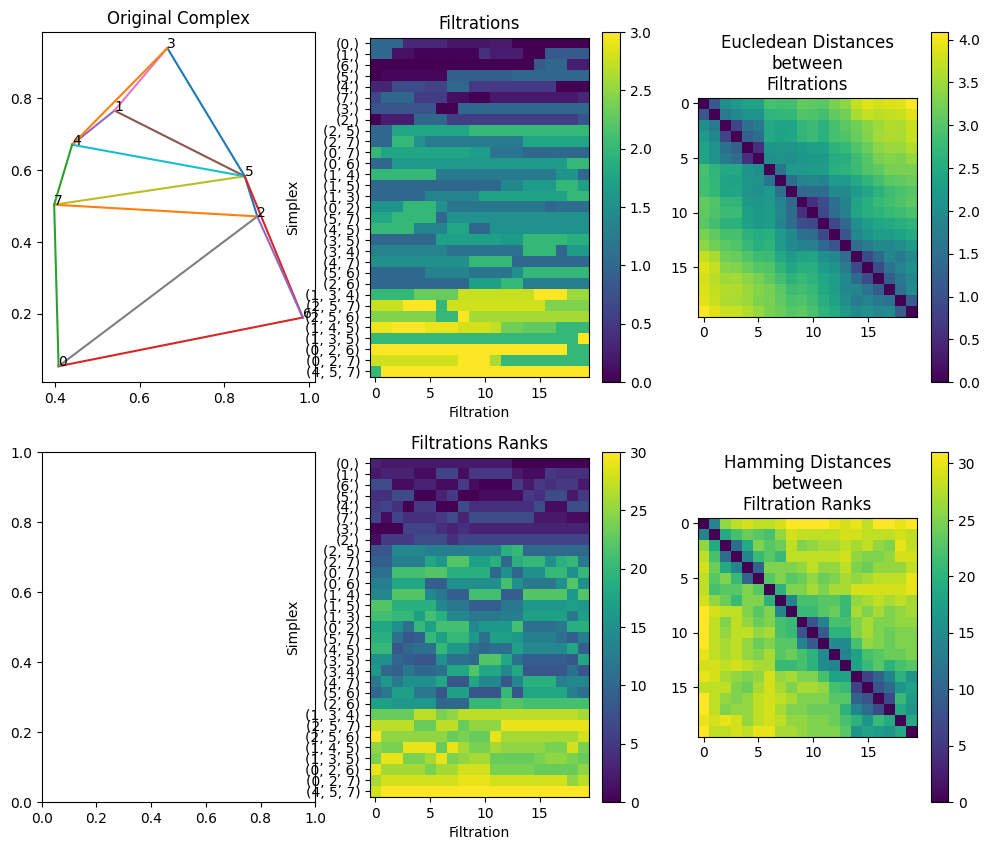

In [219]:
n_filtrations = 20
variance = 0.1
unchanged_prob = 0.8

n = 8
dim = 2
points = np.random.random([n, dim])

stree = gh.AlphaComplex(points).create_simplex_tree()

simplices = np.array([tuple(s) for s, f_val in stree.get_simplices()], dtype=object)

simplices_dimensions = np.array([len(s) - 1 for s in simplices])
simplices = simplices[simplices_dimensions.argsort()]
simplices_dimensions = np.array([len(s) - 1 for s in simplices])



#filtrations = np.random.random(size=[n_filtrations, len(simplices)])
filtrations = np.random.random(len(simplices)) + np.ones([n_filtrations, len(simplices)])

filtrations_add = variance*np.random.normal(size=[n_filtrations, len(simplices)])
filtrations_add[0] = 0
filtrations_add[np.random.random(filtrations_add.shape) < unchanged_prob] = 0
filtrations_add = np.cumsum(filtrations_add, axis=0)

filtrations = filtrations + filtrations_add
filtrations = (filtrations - filtrations.min(axis=0)) / (filtrations.max(axis=0) - filtrations.min(axis=0))

for d in range(dim + 1):
    filtrations[:, simplices_dimensions == d] += d

filtrations_rank = filtrations.argsort(axis=1)

filtrations_distances = cdist(filtrations, filtrations, metric='euclidean')
filtrations_rank_distances = cdist(filtrations_rank, filtrations_rank, metric='hamming')*len(simplices)

fig, axs = plt.subplots(2, 3, figsize=(12, 10))

axs[0, 0].set_title('Original Complex')
for simplex in simplices[simplices_dimensions == 1]:
    axs[0, 0].plot(points[simplex, 0], points[simplex, 1])
enumerate_points(points, ax=axs[0, 0])

axs[0, 1].set_title('Filtrations')
sm = axs[0, 1].imshow(filtrations.transpose(), vmin=0, vmax=dim+1)
plt.colorbar(sm, ax=axs[0, 1])
axs[0, 1].set_ylabel('Simplex')
axs[0, 1].set_xlabel('Filtration')
axs[0, 1].set_yticks(np.arange(len(simplices)), simplices)

axs[0, 2].set_title('Eucledean Distances\nbetween\nFiltrations')
sm = axs[0, 2].imshow(filtrations_distances.transpose())
plt.colorbar(sm, ax=axs[0, 2])

axs[1, 1].set_title('Filtrations Ranks')
sm = axs[1, 1].imshow(filtrations_rank.transpose())
plt.colorbar(sm, ax=axs[1, 1])
axs[1, 1].set_ylabel('Simplex')
axs[1, 1].set_xlabel('Filtration')
axs[1, 1].set_yticks(np.arange(len(simplices)), simplices)

axs[1, 2].set_title('Hamming Distances\nbetween\nFiltration Ranks')
sm = axs[1, 2].imshow(filtrations_rank_distances.transpose())
plt.colorbar(sm, ax=axs[1, 2])

plt.show()